In [1]:
# Use if you run the notebook on Google colab
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
!pip install mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 8.1 MB/s eta 0:00:00


# 10: K-Means Clustering

## Imports

You need to install the following package in the course environment.
```
conda install -c districtdatalabs yellowbrick
```

In [6]:
import os
import random
import sys
import time

import numpy as np

sys.path.append("/content/drive/MyDrive/50603/code")
os.chdir('/content/drive/MyDrive/50603')
from IPython.display import HTML, Image, display
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
from plotting_functions import *
from plotting_functions_unsup import *
from sklearn import cluster, datasets, metrics
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

plt.style.use("seaborn-v0_8")

%matplotlib inline

### Learning outcomes <a name="lo"></a>

From this lecture, students are expected to be able to:

- Explain the unsupervised paradigm.
- Explain the motivation and potential applications of clustering.
- Define the clustering problem.
- Broadly explain the K-Means algorithm.  
- Apply `sklearn`'s `KMeans` algorithm.  
- Point out pros and cons of K-Means and the difficulties associated with choosing the right number of clusters.   
- Create the Elbow plot for a given dataset.
- Visualize clusters in low dimensional space.
- Use clustering for customer segmentation problem.
- Interpret the clusters discovered by K-Means.

## Introduction to unsupervised learning

### Types of machine learning

Recall the typical learning problems we discussed at the beginning of the course.

- Supervised learning ([Gmail spam filtering](https://support.google.com/a/answer/2368132?hl=en))
    - Training a model from input data and its corresponding targets to predict targets for new examples.
- **Unsupervised learning** ([Google News](https://news.google.com/))
    - Training a model to find patterns in a dataset, typically an unlabeled dataset.
- Reinforcement learning ([AlphaGo](https://deepmind.com/research/case-studies/alphago-the-story-so-far))
    - A family of algorithms for finding suitable actions to take in a given situation in order to maximize a reward.
- **Recommendation systems** ([Amazon item recommendation system](https://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf))
    - Predict the "rating" or "preference" a user would give to an item.    

### Supervised learning

- Training data comprises a set of observations ($X$) and their corresponding targets ($y$).
- We wish to find a model function $f$ that relates $X$ to $y$.
- Then use that model function to predict the targets of new examples.
- We have been working with this set up so far.

<!-- ![](img/sup-learning.png) -->

<!-- <img src="img/sup-learning.png" width="800">  -->

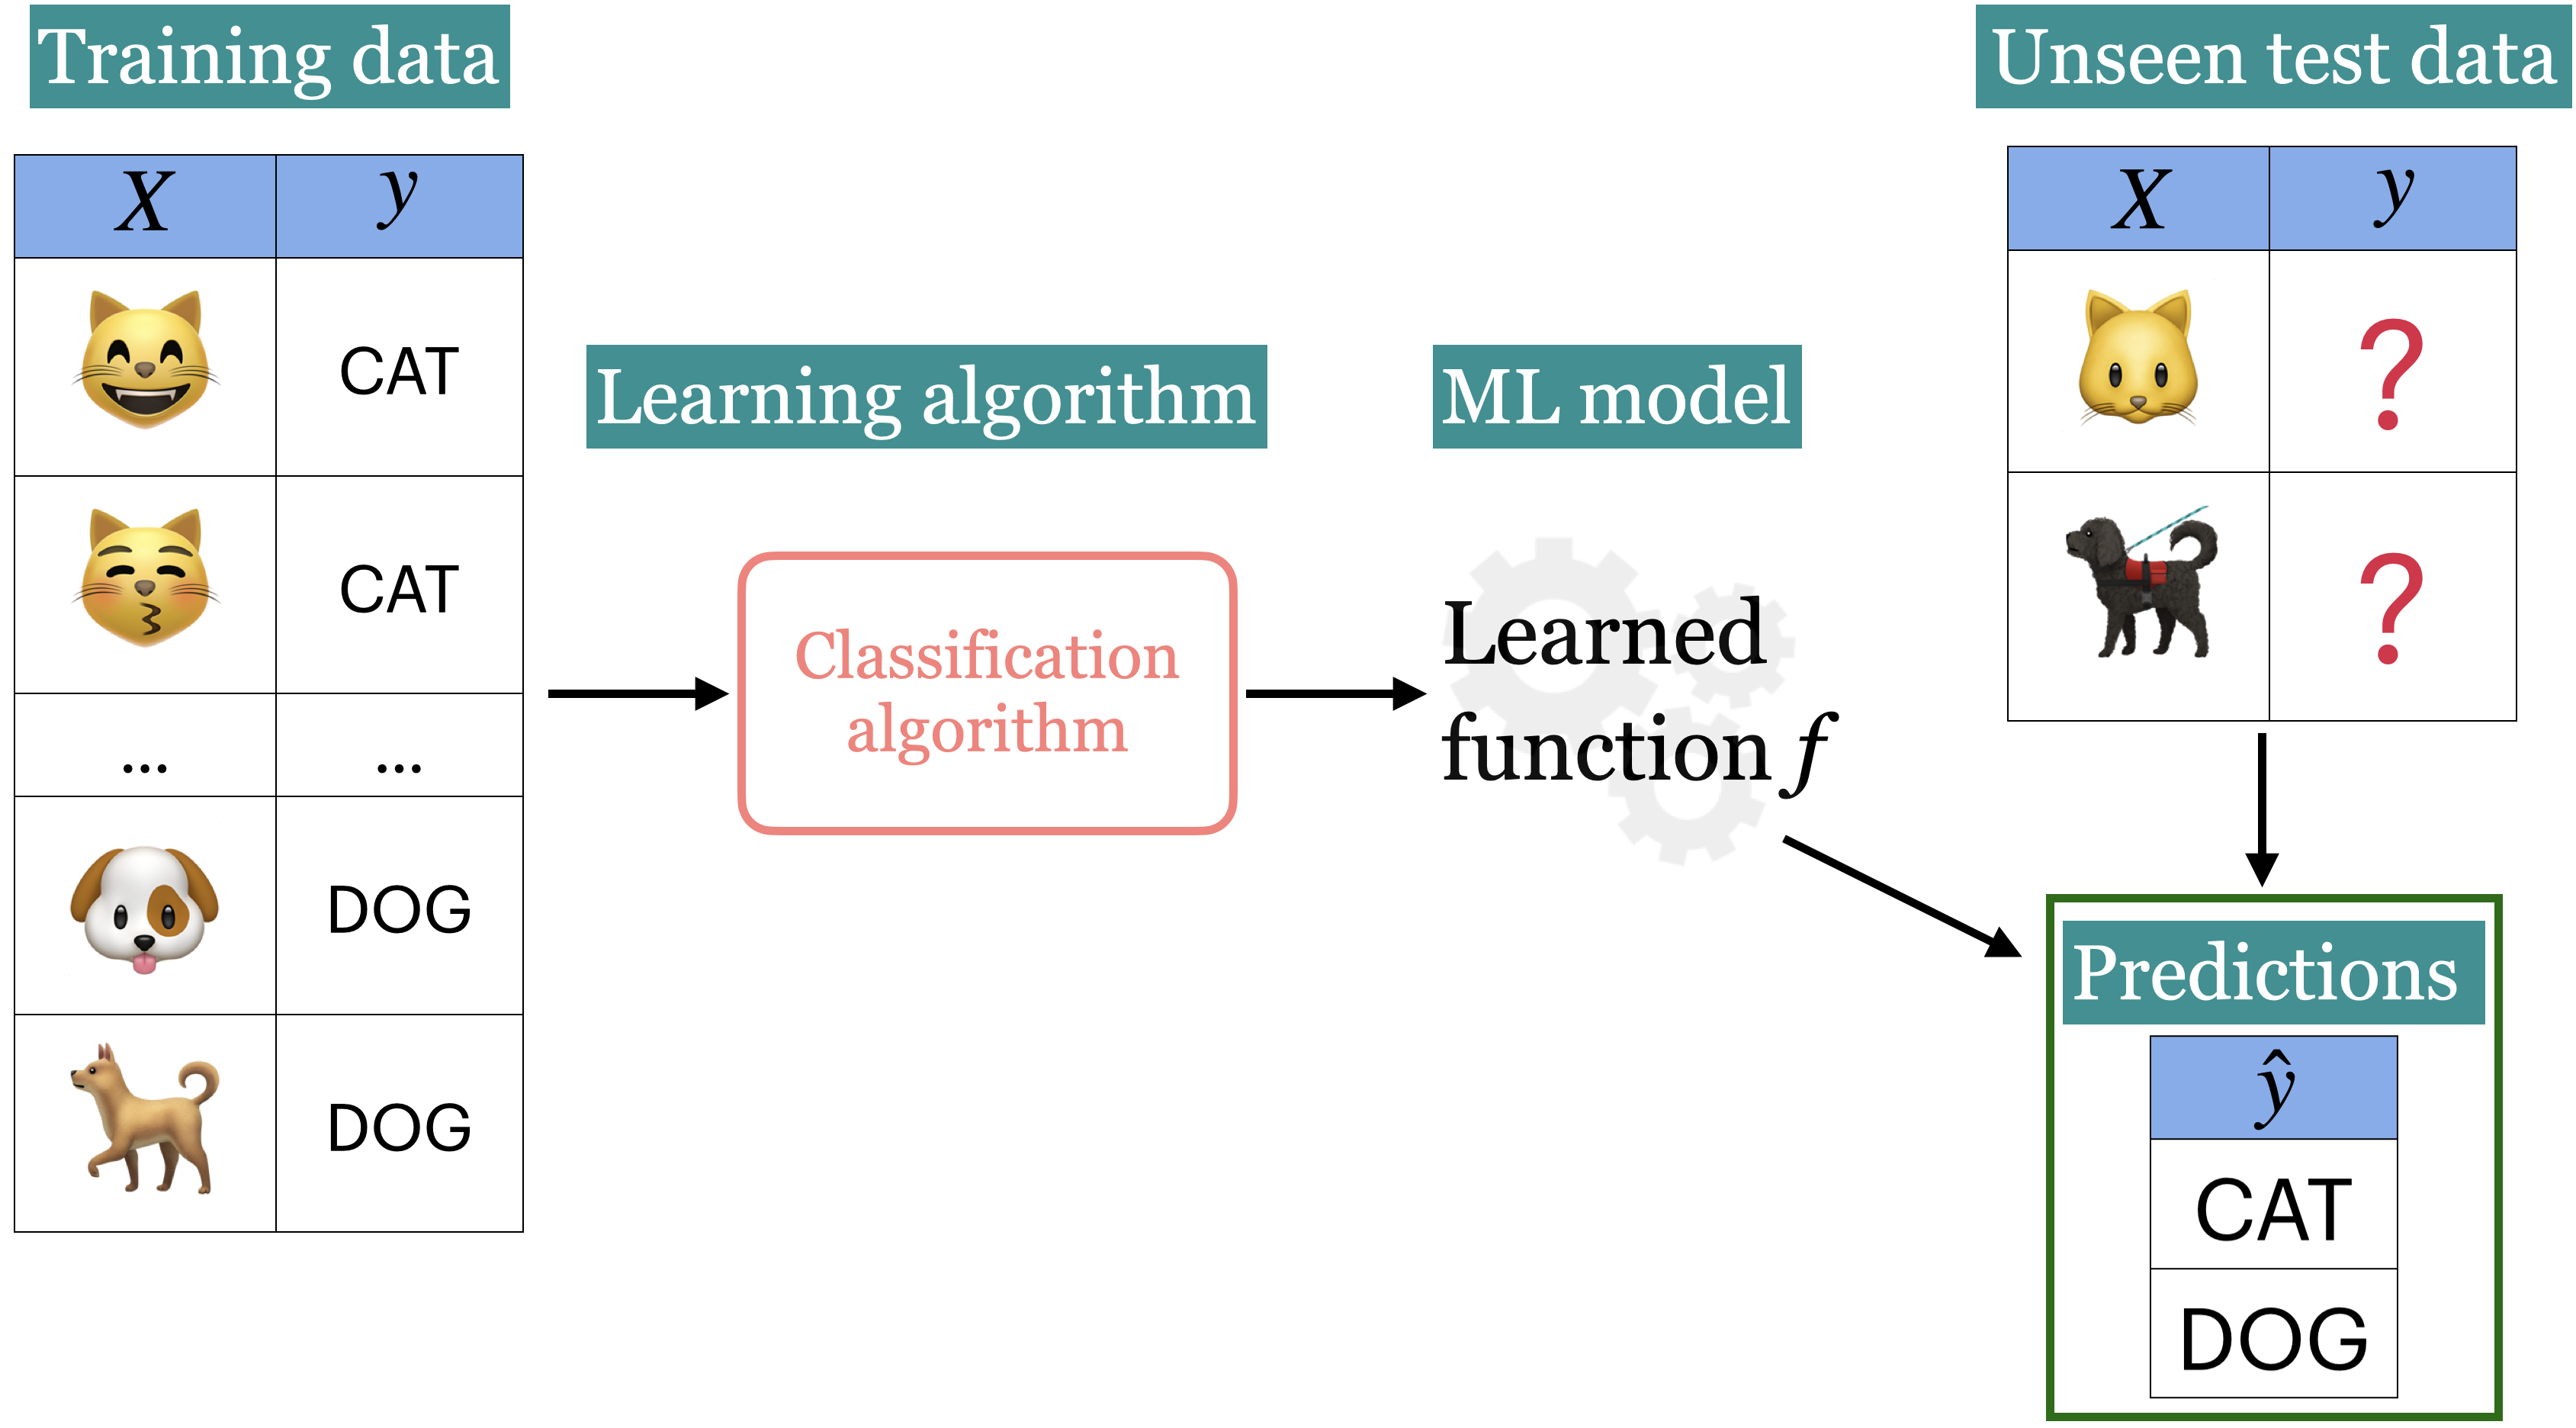

In [7]:
p = 'img/sup-learning.png'
display(Image(filename=p, width=800))

### Unsupervised learning

- Training data consists of observations ($X$) **without any corresponding targets**.
- Unsupervised learning could be used to **group similar things** together in $X$ or to find **underlying structure** in the data.

<!-- ![](img/unsup-learning.png) -->

<!-- <img src="img/unsup-learning.png" alt="" width="800">  -->

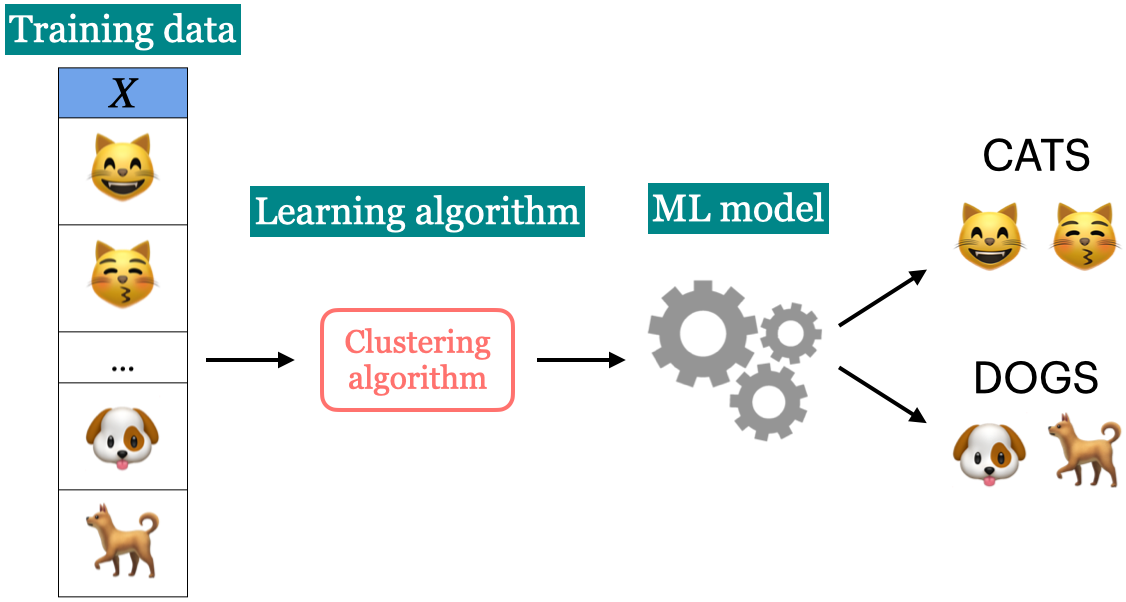

In [8]:
p = 'img/unsup-learning.png'
display(Image(filename=p, width=800))

### Can we learn without targets?

- Yes, but the learning will be focused on finding the underlying structures of the inputs themselves (rather than finding the function $f$ between input and output like we did in supervised learning models).

- Examples:
    - Clustering (this course)
    - Dimensionality reduction (requires some math, not covered in this course)

### Labeled vs. Unlabeled data
- If you have access to labeled training data, you're in the "supervised" setting.
- You know what to do in that case from the previous lectures
- Unfortunately, getting large amount of labeled training data is often time consuming and expensive.
- Annotated data can become "stale" after a while in cases such as fraud detection.
- Can you still make sense of the data even though you do not have the labels?
- Yes! At least to a certain extent!

### Example: Supervised vs unsupervised learning

- In supervised learning, we are given features $X$ and target $y$.


<table>
<tr style="background-color:white;">
    <td>
        <table>
            <tr>
                <td colspan="2" style="text-align:center;"> <b>Dataset 1</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$y$</td>
            </tr>
            <tr>
                <td> 101.0
                <td> Sick
            </tr>
            <tr>
                <td> 98.5
                <td> Not Sick
            </tr>
            <tr>
                <td> 93.8
                <td> Sick
            </tr>
            <tr>
                <td> 104.3
                <td> Sick
            </tr>
            <tr>
                <td> 98.6
                <td> Not Sick
            </tr>
        </table>
    </td>
    <td> &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; </td>
    <td>
       <table>
            <tr>
                <td colspan="3" style="text-align:center;"> <b>Dataset2</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$x_2$</td>
                <td>$y$</td>
            </tr>
            <tr>
                <td> -2.68
                <td> 0.32
                <td>class 1
            </tr>
            <tr>
                <td> -2.71
                <td> -0.18
                <td> class 1
            </tr>
            <tr>
                <td> 1.28  
                <td> 0.69    
                <td> class 2
            </tr>
            <tr>
                <td> 0.93  
                <td> 0.32   
                <td> class 2
            </tr>
            <tr>
                <td> 1.39
                <td> -0.28
                <td> class 3
            </tr>
        </table>
    </td>
</tr>
</table>

- In unsupervised learning, we are only given features $X$.

<table>
<tr style="background-color:white;">
    <td>
        <table>
            <tr>
                <td colspan="2" style="text-align:center;"> <b>Dataset 1</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
            </tr>
            <tr>
                <td> 101.0
            </tr>
            <tr>
                <td> 98.5
            </tr>
            <tr>
                <td> 93.8
            </tr>
            <tr>
                <td> 104.3
            </tr>
            <tr>
                <td> 98.6
            </tr>
        </table>
    </td>
    <td> &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; </td>
    <td>
       <table>
            <tr>
                <td colspan="3" style="text-align:center;"> <b>Dataset 2</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$x_2$</td>
            </tr>
            <tr>
                <td> -2.68
                <td> 0.32
            </tr>
            <tr>
                <td> -2.71
                <td> -0.18
            </tr>
            <tr>
                <td> 1.28  
                <td> 0.69    
            </tr>
            <tr>
                <td> 0.93  
                <td> 0.32   
            </tr>
            <tr>
                <td> 1.39
                <td> -0.28
            </tr>
        </table>
    </td>
</tr>
</table>

### Example: a `sklearn` toy dataset

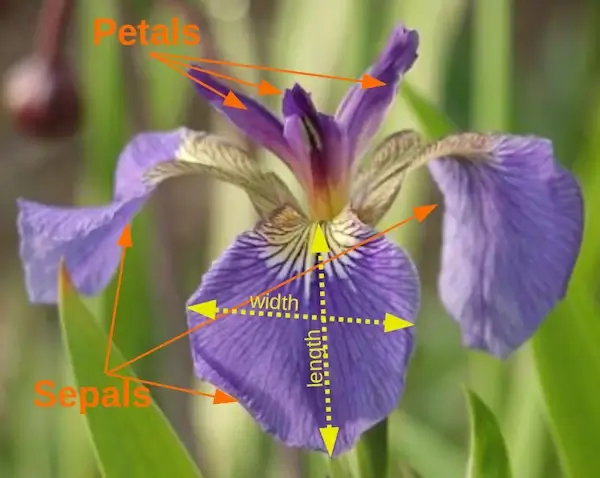

In [9]:
p = 'img/sepals_and_petals_600w.png'
display(Image(filename=p, width=400))

<!-- ![](img/sepals_and_petals_600w.png) -->

<!-- <img src="img/sepals_and_petals_600w.png" alt="Iris" width="400">  -->

[Source](https://python-course.eu/machine-learning/data-representation-and-visualization-data.php)


In [10]:
## Iris dataset
iris = datasets.load_iris()  # loading the iris dataset
features = iris.data[:, 2:4]  # only consider two features for visualization
labels = iris.target_names[
    iris.target
]  # get the targets, in this case the types of the Iris flower

iris_df = pd.DataFrame(features, columns=iris.feature_names[2:]).assign(target=labels)
iris_df.sample(10).sort_index()

petal length (cm)  petal width (cm)      target
5                  1.7               0.4      setosa
25                 1.6               0.2      setosa
26                 1.6               0.4      setosa
38                 1.3               0.2      setosa
59                 3.9               1.4  versicolor
68                 4.5               1.5  versicolor
87                 4.4               1.3  versicolor
94                 4.2               1.3  versicolor
101                5.1               1.9   virginica
135                6.1               2.3   virginica

In [11]:
np.unique(labels)

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

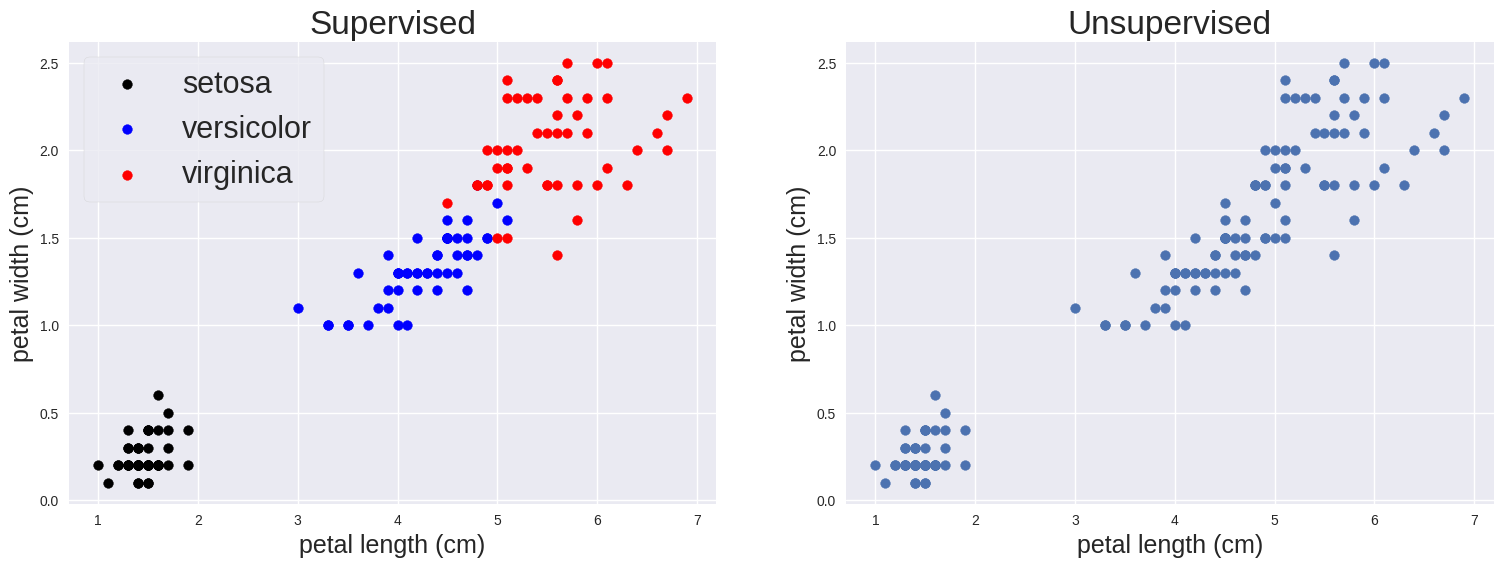

In [12]:
plot_sup_x_unsup(iris_df, w=6, h=6)

<br><br><br><br>

## Clustering motivation [[video](https://youtu.be/caAuUAXwpb8)]

Assume we have a collection of images:
- If you want to build a machine learning model to cluster these images how would you represent the images?
- Do you think there is one correct way to cluster these images?
- Imagine that we also have ratings data of food items and users for a large number of users. Can you exploit the power of community to recommend certain food items to a given user they are likely to consume?

### Why clustering?

- Most of the data out there is unlabeled.  
- Getting labeled training data is often difficult, expensive, or simply impossible in some cases.
- Can we extract some useful information from unlabeled data?
- The most intuitive way is to group similar examples together to get some insight into the data even though we do not have the targets.  

### Clustering  

**Clustering** is the task of partitioning the dataset into groups called clusters.

The goal of clustering is to discover underlying groups in a given dataset such that:
- examples in the same group are as similar as possible;
- examples in different groups are as different as possible.          

### Input and possible output

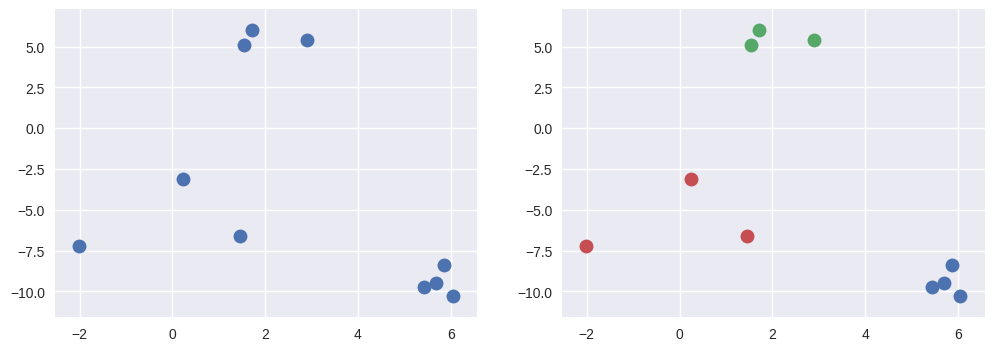

In [13]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o", ax=axes[0])
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, markers="o", ax=axes[1]);

Think of clustering as colouring the points (e.g., blue, red, green) such that points with the same color are close to each other.

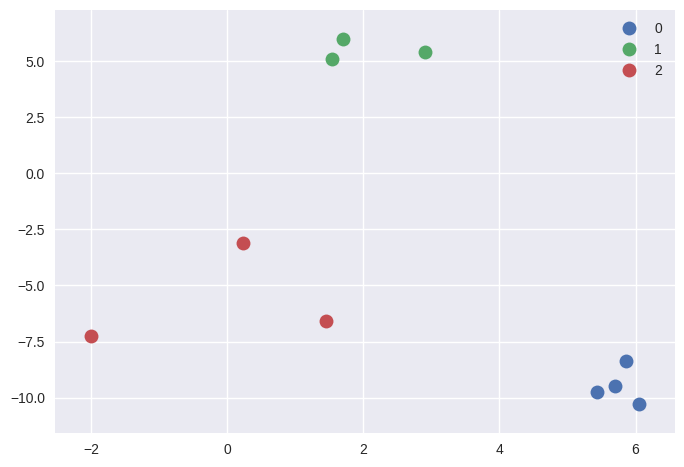

In [14]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, markers="o")
plt.legend();

- Usually the clusters are identified by a **cluster label**.
- These labels are arbitrary, and relabeling the points (label switching) does not make a difference.
- What we care about is which points have the same labels and which ones have different labels.

### Is there a notion of "correct" grouping?

- Very often we do not know how many clusters are there in the data or if there are any clusters at all. In real-world data, clusters are rarely as clear as in our toy example above.
- There is a notion of coherent and optimal (in some sense) clusters but there is no absolute truth here.

### Example 1
Which of the following grouping of emoticons is the "correct" grouping?

<!-- ![](img/emoticon_clustering_example.png) -->

<!-- <img src="img/emoticon_clustering_example.png" alt="" width="800">  -->

In [15]:
p = 'img/emoticon_clustering_example.png'
display(Image(filename=p, width=800))

Output hidden; open in https://colab.research.google.com to view.

Both seem reasonable!

### Meaningful groups in clustering
- In clustering, meaningful groups are dependent on the **application**.
- It usually helps if we have some prior knowledge about the data and the problem.   
- This makes it hard for us to objectively measure the quality of a clustering algorithm (or think about "true" clusters).

### Common applications: Data exploration

Although there is no notion of the "right" answer, we might still get something useful out of clustering. There are a number of common applications for clustering.

- Summarize or compress data.
- Partition the data into groups before further processing.
- For instance, you could use it in supervised learning setting as follows. Carry out clustering and examine performance of your model on individual clusters. If the performance is lower on a particular cluster, you could either try building a separate model for that cluster and improve the overall performance of your supervised model.

### Common applications: Customer segmentation

- Understand landscape of the market in businesses and craft targeted business or marketing strategies tailored for each group.

<!-- ![](img/customer-segmentation.png) -->

<!-- <img src="img/customer-segmentation.png" alt="" width="600"> -->

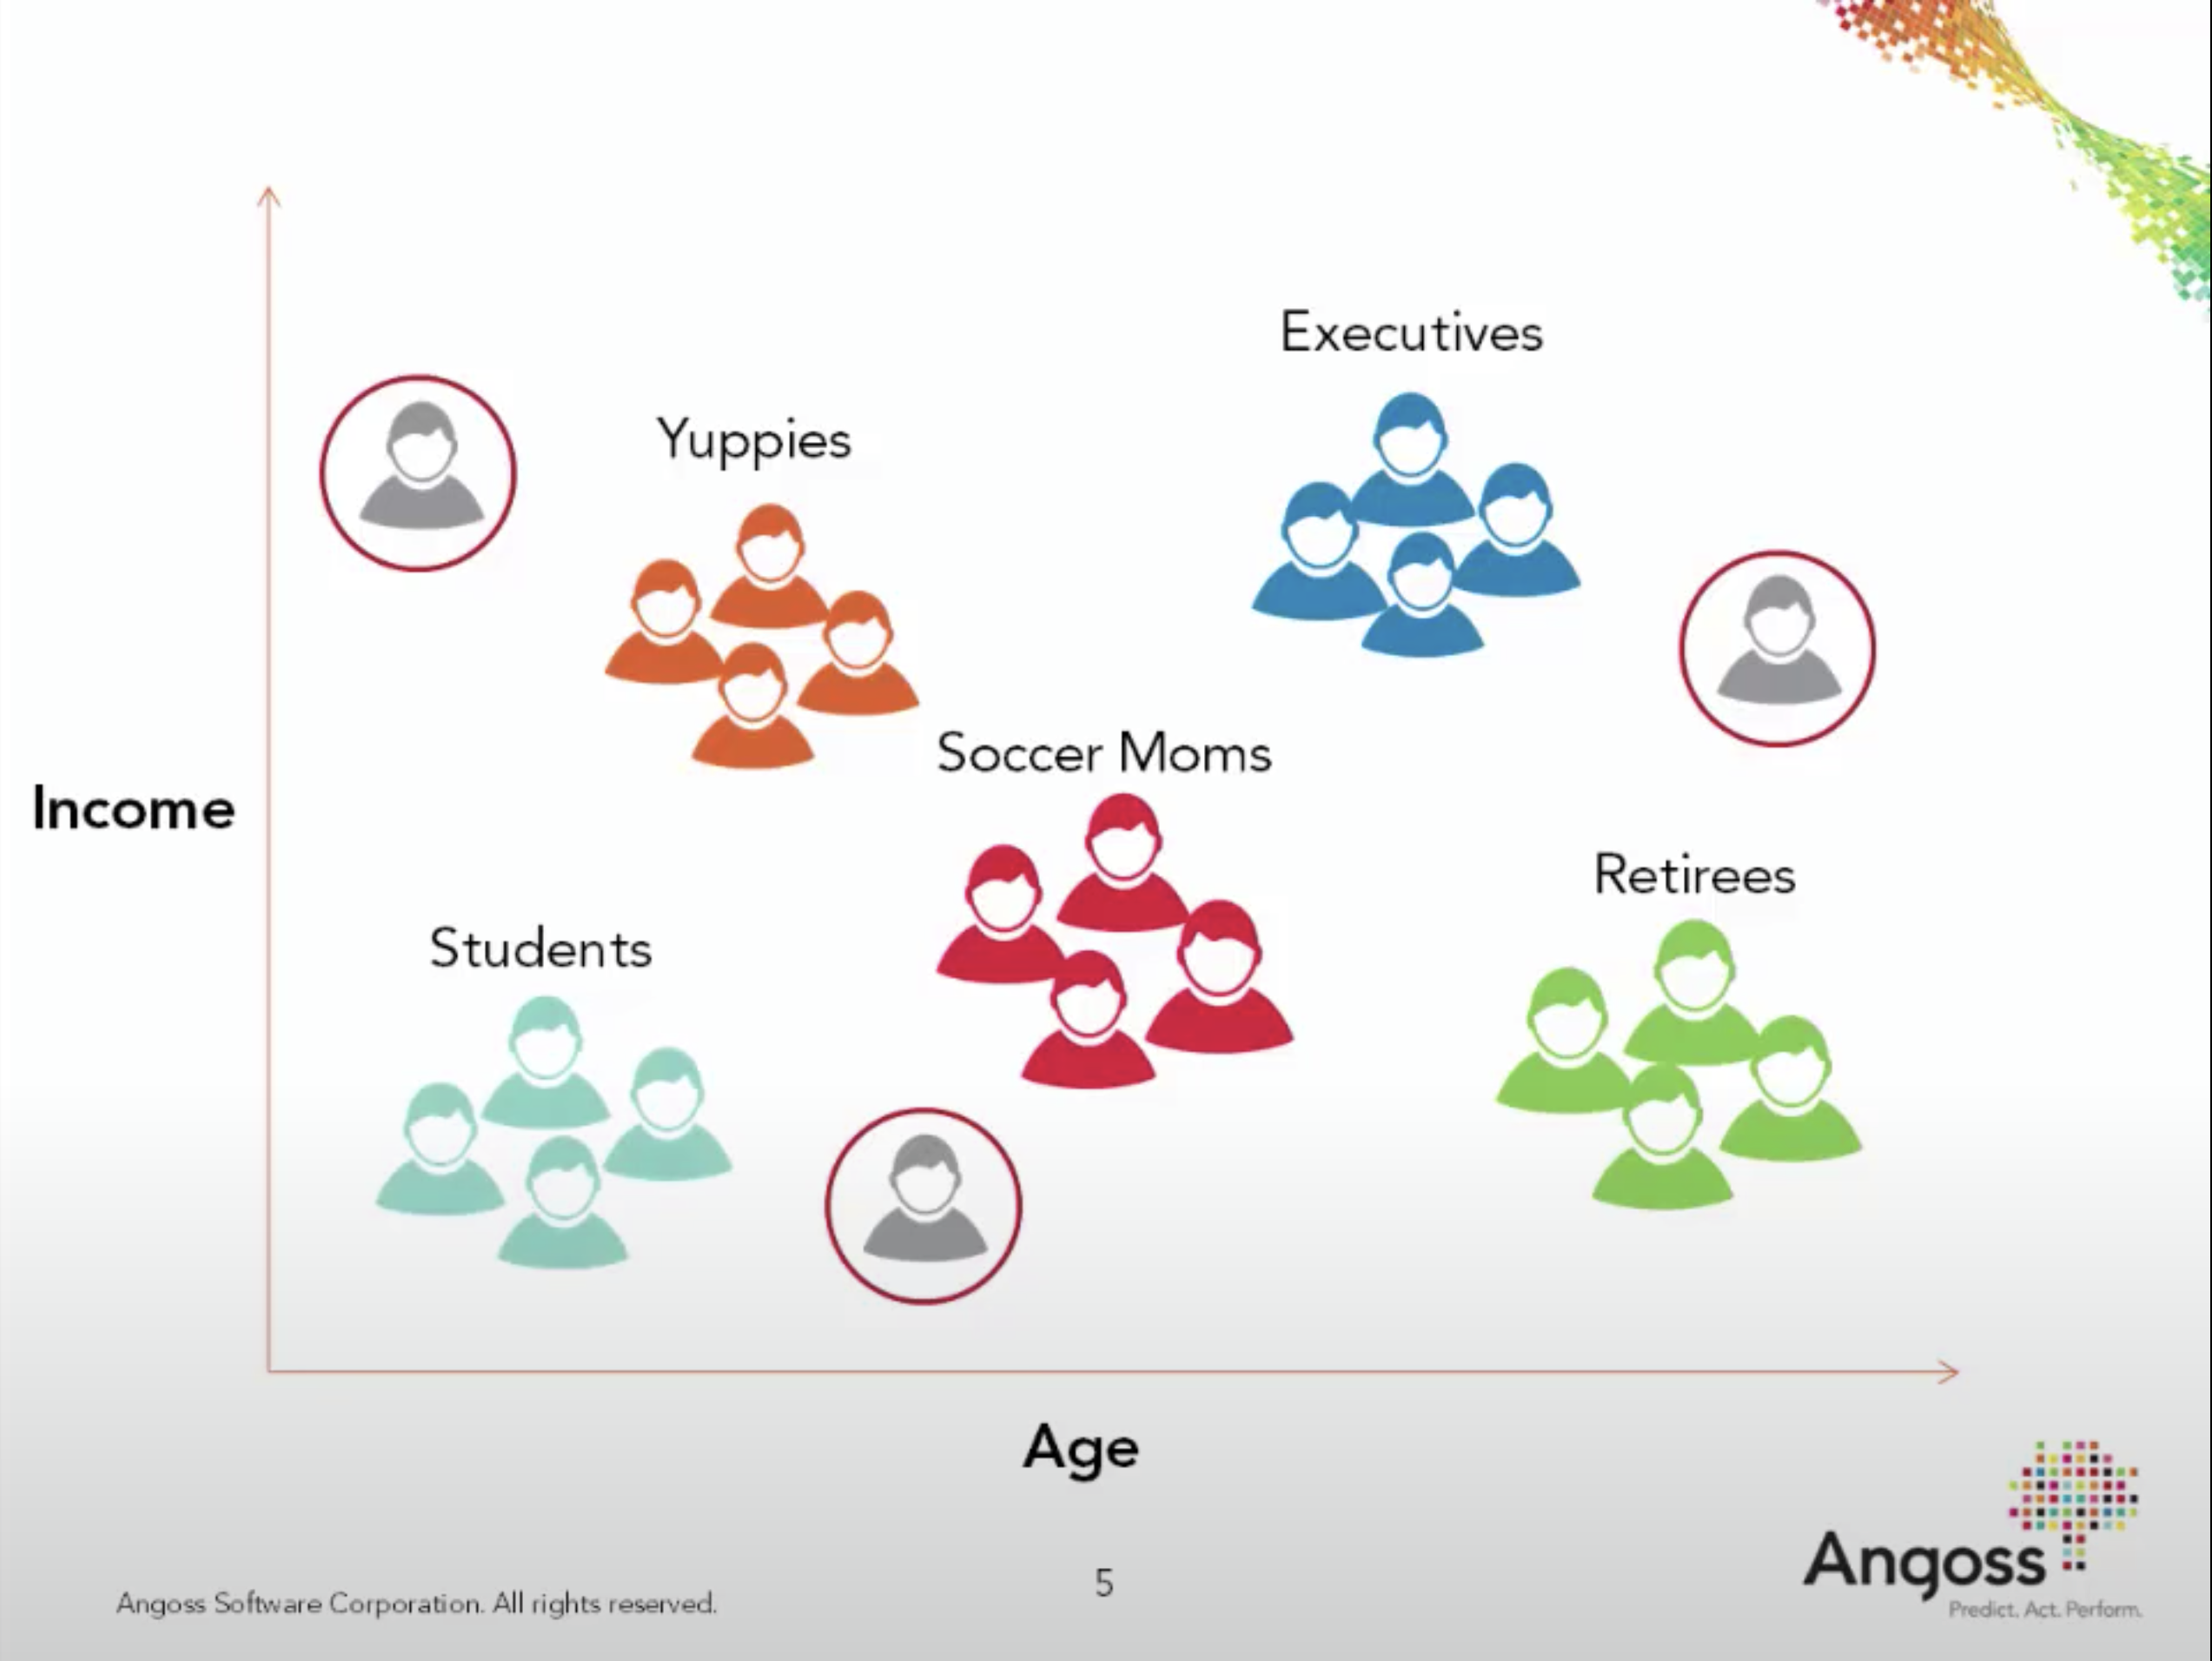

In [16]:
p = 'img/customer-segmentation.png'
display(Image(filename=p, width=600))

[source](https://www.youtube.com/watch?v=zPJtDohab-g&t=134s)

### Similarity and distances

- Clustering is based on the notion of similarity or distances between points.
- How do we determine similarity between points in a multi-dimensional space?
- Can we use something like $k$-neighbours for similarity?
    - Yes! That's a good start!  
    - With $k$-neighbours we used Euclidean distances to find nearby points.
    - We can use the same idea for clustering!


<br><br><br><br><br>

## K-Means clustering algorithm [[video](https://youtu.be/s6AvSZ1_l7I)]

### K-Means clustering

One of the most commonly used clustering algorithm.

**Input**
- `X` $\rightarrow$ a set of data points  
- `K` (or $k$ or `n_clusters`) $\rightarrow$ number of clusters

**Output**
- `K` clusters (groups) of the data points



### K-Means using `sklearn`
- Before understanding the algorithm, let's try it with `sklearn`.
- Consider the toy dataset above.
- For this toy dataset, the three clusters are pretty clear.  

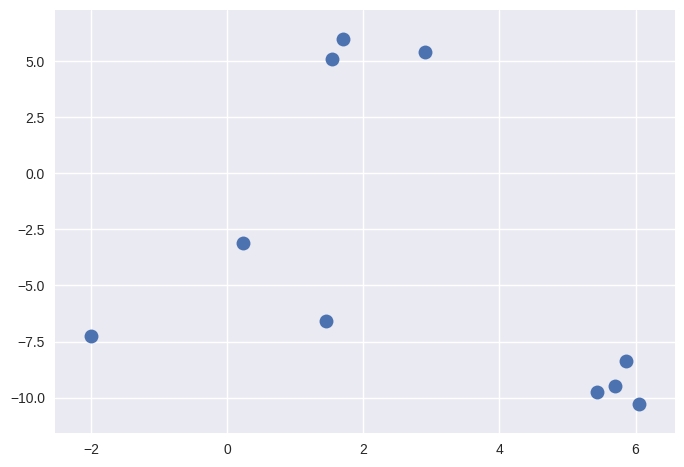

In [17]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o");

In [18]:
X

array([[  5.69192445,  -9.47641249],
       [  1.70789903,   6.00435173],
       [  0.23621041,  -3.11909976],
       [  2.90159483,   5.42121526],
       [  5.85943906,  -8.38192364],
       [  6.04774884, -10.30504657],
       [ -2.00758803,  -7.24743939],
       [  1.45467725,  -6.58387198],
       [  1.53636249,   5.11121453],
       [  5.4307043 ,  -9.75956122]])

In [19]:
toy_df = pd.DataFrame(data=X, columns=["feat1", "feat2"])
toy_df

feat1      feat2
0  5.691924  -9.476412
1  1.707899   6.004352
2  0.236210  -3.119100
3  2.901595   5.421215
4  5.859439  -8.381924
5  6.047749 -10.305047
6 -2.007588  -7.247439
7  1.454677  -6.583872
8  1.536362   5.111215
9  5.430704  -9.759561

### `KMeans` `fit`
Let's try `sklearn`'s `KMeans` algorithm on this dataset.
- We need to decide how many clusters we want. Here we are passing 3.
- We are only passing `X` because this is unsupervised learning; we do not have labels.  

In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
# We are only passing X because this is unsupervised learning

KMeans(n_clusters=3)

### `predict` of `KMeans`

- The output of `KMeans` is $K$ clusters (groups) of the data points.
- Calling `predict` will give us the cluster assignment for each data point.

In [21]:
kmeans.predict(X)

array([2, 1, 0, 1, 2, 2, 0, 0, 1, 2], dtype=int32)

In [22]:
toy_df_cl = toy_df.copy()
toy_df_cl["cluster"] = kmeans.predict(toy_df.to_numpy())
toy_df_cl

feat1      feat2  cluster
0  5.691924  -9.476412        2
1  1.707899   6.004352        1
2  0.236210  -3.119100        0
3  2.901595   5.421215        1
4  5.859439  -8.381924        2
5  6.047749 -10.305047        2
6 -2.007588  -7.247439        0
7  1.454677  -6.583872        0
8  1.536362   5.111215        1
9  5.430704  -9.759561        2

### Cluster centers in  K-Means

- In K-Means each cluster is represented by its cluster center.

In [23]:
kmeans.cluster_centers_

array([[-0.10556679, -5.65013704],
       [ 2.04861878,  5.51226051],
       [ 5.75745416, -9.48073598]])

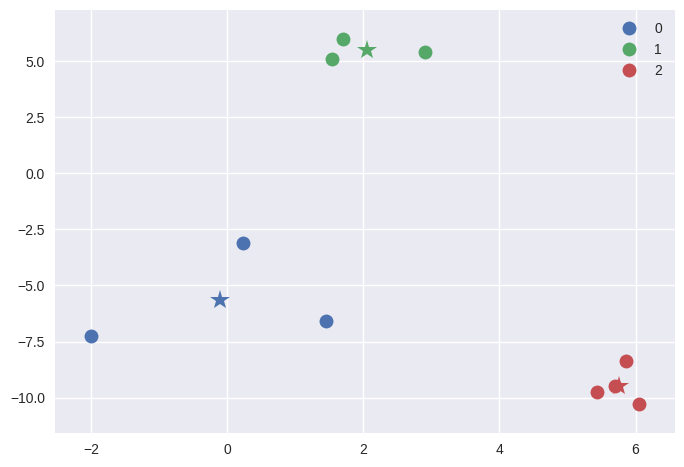

In [24]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers="*", s=15
);

### K-Means predictions on new examples
- We can also use `predict` on unseen examples!  

In [25]:
new_examples = np.array([[-1, -5], [2, 5.0]])
new_examples_pred = kmeans.predict(new_examples)
new_examples_pred

array([0, 1], dtype=int32)

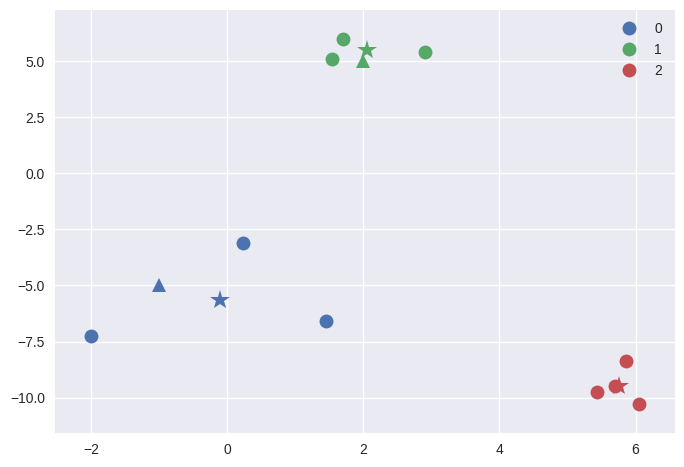

In [26]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
mglearn.discrete_scatter(new_examples[:, 0], new_examples[:, 1], new_examples_pred, markers="^")
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers="*", s=15
);

### K-Means algorithm: Main idea

- Represent each cluster by its cluster center and assign a cluster membership to each data point.

**Chicken-and-egg problem!**

- If we knew cluster centers, we can simply assign each point to its nearest center.
- Similarly, if we knew assignments, we can calculate cluster centers.  
- But we do not know either 😟.

A usual computer science answer to such problems is iterations!!

### K-Means clustering algorithm

**Input**: Data points X and the number of clusters K

**Initialization**: K initial centers for the clusters

**Iterative process**:

repeat
- Assign each example to the closest center.
- Estimate new centers as _average_ of observations in a cluster.

until **centers stop changing** or **maximum iterations have reached**.

Let's execute K-Means algorithm on our toy example.

**Input**
- The data points `X`

In [27]:
n_examples = toy_df.shape[0]
print("Number of examples: ", n_examples)
X

Number of examples:  10


array([[  5.69192445,  -9.47641249],
       [  1.70789903,   6.00435173],
       [  0.23621041,  -3.11909976],
       [  2.90159483,   5.42121526],
       [  5.85943906,  -8.38192364],
       [  6.04774884, -10.30504657],
       [ -2.00758803,  -7.24743939],
       [  1.45467725,  -6.58387198],
       [  1.53636249,   5.11121453],
       [  5.4307043 ,  -9.75956122]])

- Let K (number of clusters) be 3.

In [28]:
k = 3

### Initialization

- Random initialization for K initial centers of the clusters.

In [29]:
np.random.seed(seed=14)
centers_idx = np.random.choice(range(0, n_examples), size=k)
centers_df = toy_df.iloc[centers_idx]
centers = X[centers_idx]
colours = ["black", "blue", "red"]

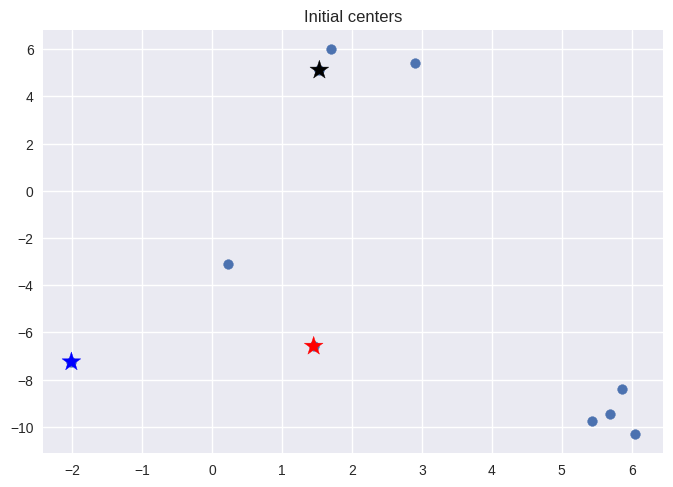

In [30]:
plt.scatter(X[:, 0], X[:, 1], marker="o")
plt.scatter(centers[:, 0], centers[:, 1], c=colours, marker="*", s=200)
plt.title("Initial centers");

### Iterative process

Recall:

In [31]:
pd.DataFrame(centers, columns=['feat1', 'feat2'])

feat1     feat2
0  1.536362  5.111215
1 -2.007588 -7.247439
2  1.454677 -6.583872

repeat

- Assign each example to the closest center. (`update_Z`)
- Estimate new centers as _average_ of observations in a cluster. (`update_centers`)

until **centers stop changing** or **maximum iterations have reached**.

### How to find closest centers?

- First step in the iterative process is assigning examples to the closest center.
- Let's consider distance of an example to all centers and assign that example to the closest center.  

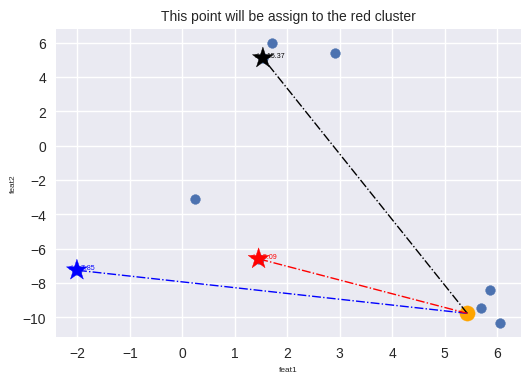

In [32]:
plot_example_dist(toy_df, centers_df, w=6, h=4)

- Similarly, we can make cluster assignments for all points by calculating distances of all examples to the centers and assigning it to the cluster with smallest distance.  

In [33]:
# Distance from each point to each center
dist = euclidean_distances(X, centers)

dist_df = pd.DataFrame(dist, columns=["to c0", "to c1", "to c2"]).rename_axis("from p", axis=1)
dist_df

from p      to c0      to c1      to c2
0       15.167978   8.015661   5.130405
1        0.909461  13.762805  12.590770
2        8.332375   4.698704   3.672779
3        1.399986  13.586570  12.091968
4       14.168760   7.948407   4.757617
5       16.062805   8.616114   5.911298
6       12.856746   0.000000   3.525280
7       11.695372   3.525280   0.000000
8        0.000000  12.856746  11.695372
9       15.372243   7.851048   5.088594

In [34]:
Z = np.argmin(dist, axis=1)
dist_df["closest c to p (Z)"] = Z
dist_df

from p      to c0      to c1      to c2  closest c to p (Z)
0       15.167978   8.015661   5.130405                   2
1        0.909461  13.762805  12.590770                   0
2        8.332375   4.698704   3.672779                   2
3        1.399986  13.586570  12.091968                   0
4       14.168760   7.948407   4.757617                   2
5       16.062805   8.616114   5.911298                   2
6       12.856746   0.000000   3.525280                   1
7       11.695372   3.525280   0.000000                   2
8        0.000000  12.856746  11.695372                   0
9       15.372243   7.851048   5.088594                   2

In [35]:
from sklearn.metrics import euclidean_distances


def update_Z(X, centers):
    """
    returns distances and updated cluster assignments
    """
    dist = euclidean_distances(X, centers)
    return dist, np.argmin(dist, axis=1)

### How to update centers?   

- With the new cluster assignments for our data points, we update cluster centers.
- New cluster centers are means of data points in each cluster.

In [36]:
Z

array([2, 0, 2, 0, 2, 2, 1, 2, 0, 2])

In [37]:
Z == 2

array([ True, False,  True, False,  True,  True, False,  True, False,
        True])

In [38]:
X[Z == 0], X[Z == 1], X[Z == 2]

(array([[1.70789903, 6.00435173],
        [2.90159483, 5.42121526],
        [1.53636249, 5.11121453]]),
 array([[-2.00758803, -7.24743939]]),
 array([[  5.69192445,  -9.47641249],
        [  0.23621041,  -3.11909976],
        [  5.85943906,  -8.38192364],
        [  6.04774884, -10.30504657],
        [  1.45467725,  -6.58387198],
        [  5.4307043 ,  -9.75956122]]))

In [39]:
np.mean(X[Z == 2], axis=0)

array([ 4.12011738, -7.93765261])

In [40]:
def update_centers(X, Z, old_centers, k):
    """
    returns new centers
    """
    new_centers = old_centers.copy()
    for kk in range(k):
        new_centers[kk] = np.mean(X[Z == kk], axis=0)
    return new_centers

### Iteration 1: Step 1

- Assign each example to the closest cluster center.

In [41]:
dist, Z = update_Z(X, centers)
Z

array([2, 0, 2, 0, 2, 2, 1, 2, 0, 2])

- This is the current cluster assignment.

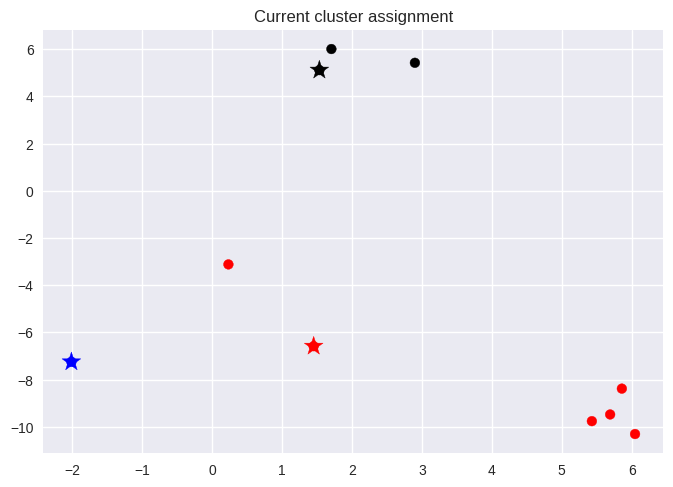

In [42]:
plot_current_assinment(X, Z, centers)

### Iteration 1: Step 2
- Estimate new centers as _average_ of observations in a cluster.

In [43]:
new_centers_it1 = update_centers(X, Z, centers, k)

- This is how the centers moved in this iteration.

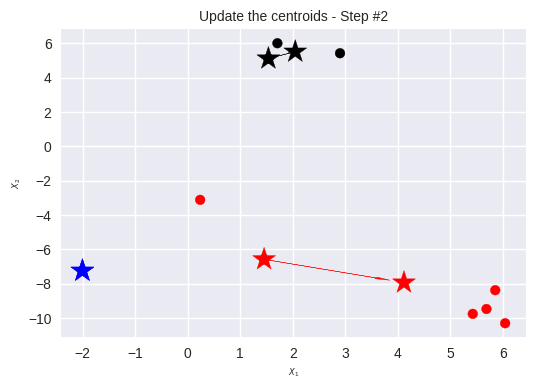

In [44]:
plot_update_centroid(toy_df, new_centers_it1, centers, dist)

### Iteration 2: step 1

- Assign each example to the closest cluster center.

In [45]:
dist, Z = update_Z(X, new_centers_it1)
Z

array([2, 0, 1, 0, 2, 2, 1, 2, 0, 2])

- This is the current cluster assignment.

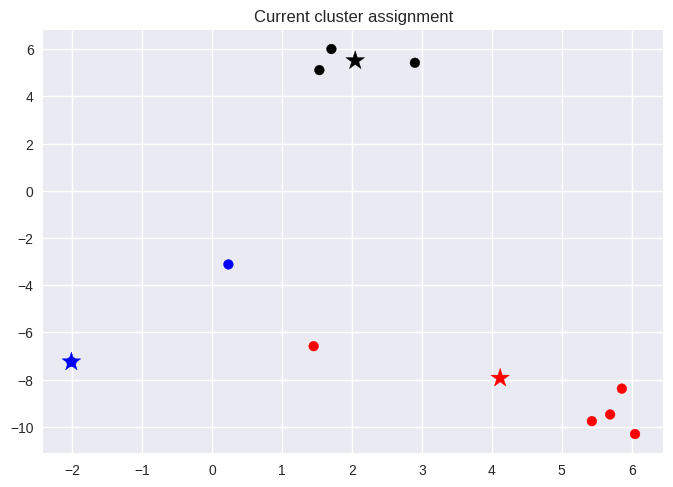

In [46]:
plot_current_assinment(X, Z, new_centers_it1)

### Iteration 2: step 2

- Estimate new centers as _average_ of observations in a cluster.

In [47]:
new_centers_it2 = update_centers(X, Z, new_centers_it1, k)

- This is how the centers moved in this iteration.

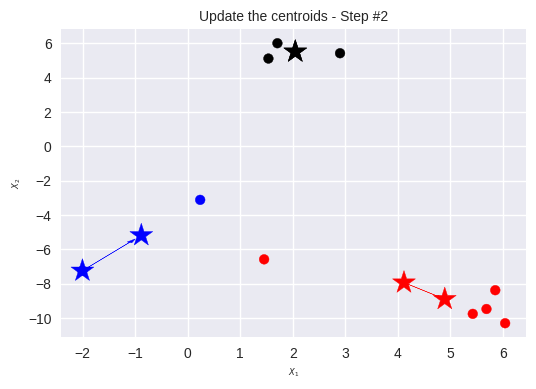

In [48]:
plot_update_centroid(toy_df, new_centers_it2, new_centers_it1, dist)

### Iteration 3: step 1

- Assign each example to the closest cluster center.

In [49]:
dist, Z = update_Z(X, new_centers_it2)
Z

array([2, 0, 1, 0, 2, 2, 1, 1, 0, 2])

- This is the current cluster assignment.

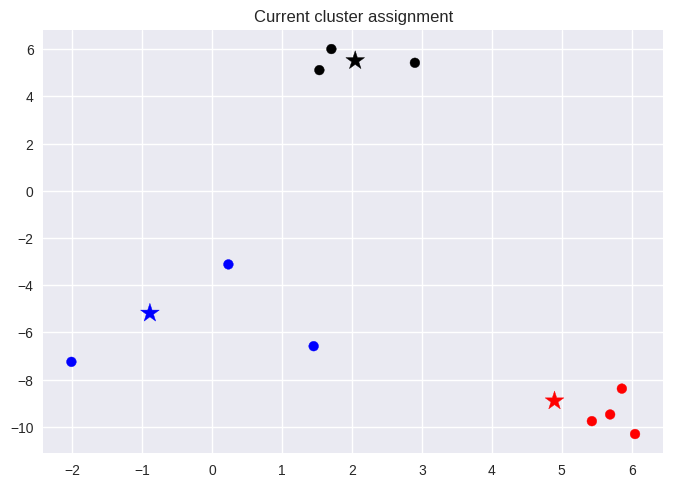

In [50]:
plot_current_assinment(X, Z, new_centers_it2)

### Iteration 3: step 2

- Estimate new centers as _average_ of observations in a cluster.

In [51]:
new_centers_it3 = update_centers(X, Z, new_centers_it2, k)

- This is how the centers moved in this iteration.

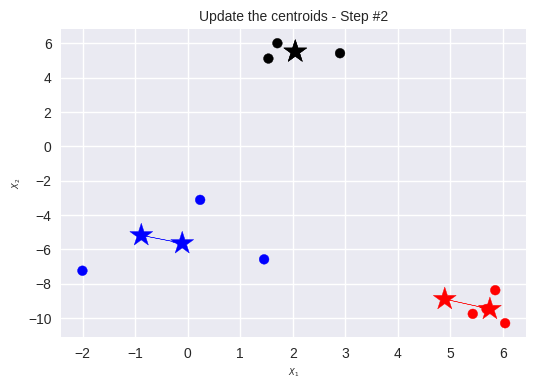

In [52]:
plot_update_centroid(toy_df, new_centers_it3, new_centers_it2, dist)

### Iteration 4: step 1

- Assign each example to the closest cluster center.

In [53]:
dist, Z = update_Z(X, new_centers_it3)
Z

array([2, 0, 1, 0, 2, 2, 1, 1, 0, 2])

- This is the current cluster assignment.

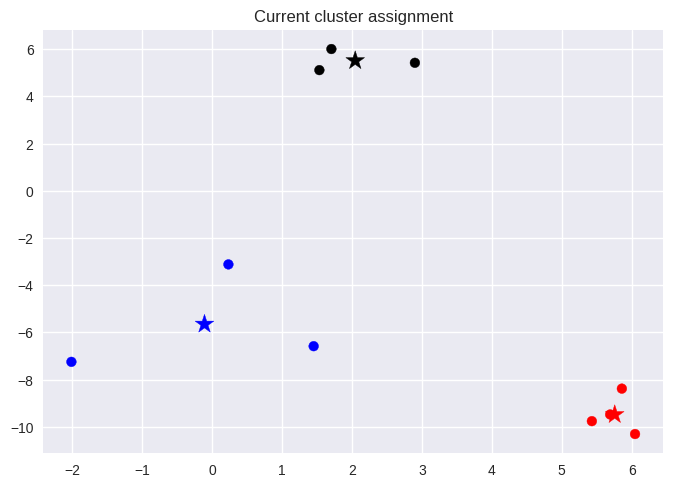

In [54]:
plot_current_assinment(X, Z, new_centers_it3)

### Iteration 4: step 2

- Estimate new centers as _average_ of observations in a cluster.

In [55]:
new_centers_it4 = update_centers(X, Z, new_centers_it3, k)

- The cluster centers are not moving anymore.

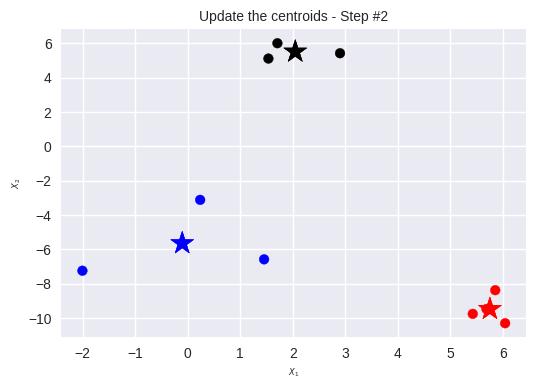

In [56]:
plot_update_centroid(toy_df, new_centers_it4, new_centers_it3, dist)

### Iteration 5: step 1

- Assign each example to the closest cluster center.

In [57]:
dist, Z = update_Z(X, new_centers_it4)
Z

array([2, 0, 1, 0, 2, 2, 1, 1, 0, 2])

- This is the current cluster assignment.

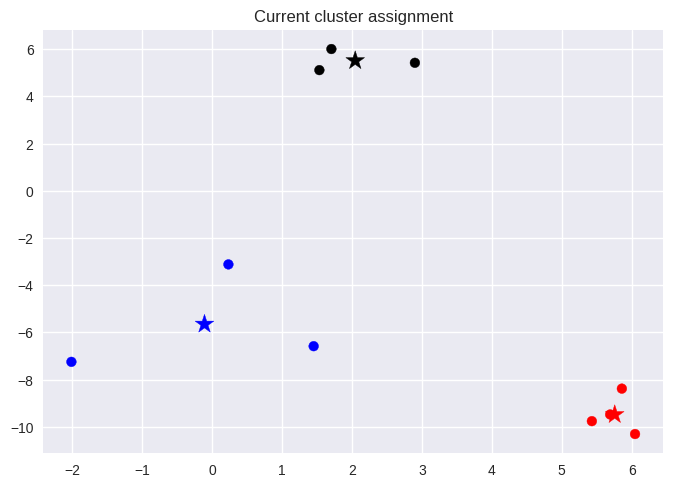

In [58]:
plot_current_assinment(X, Z, new_centers_it4)

### Iteration 5: step 2

- Estimate new centers as _average_ of observations in a cluster.

In [59]:
new_centers_it5 = update_centers(X, Z, new_centers_it4, k)

- The cluster **centers are not moving** anymore.

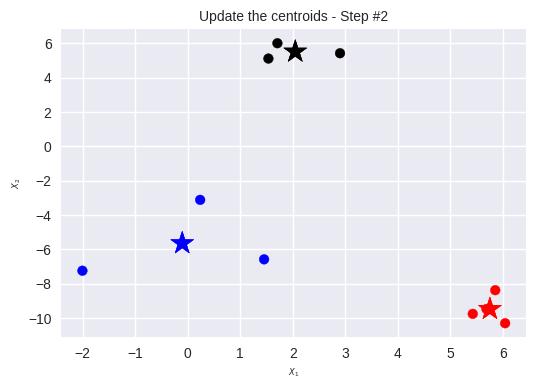

In [60]:
plot_update_centroid(toy_df, new_centers_it5, new_centers_it4, dist)

### When to stop?

- Seems like our centroids aren't changing anymore.
- The algorithm has converged. So we stop!
- K-Means always converges. It doesn't mean it finds the "right" clusters. It can converge to a sub-optimal solution.   

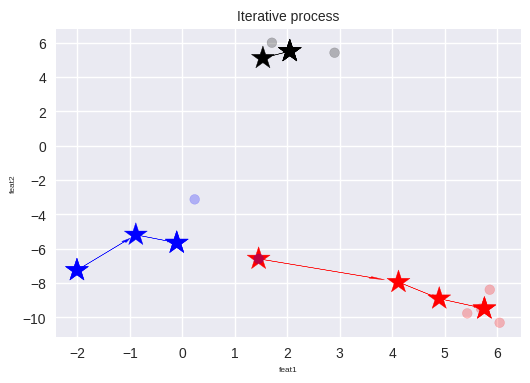

In [61]:
plot_iterative(toy_df, centers)

Initialization is crucial. We'll talk about it in a bit.

### Example 2
- Let's use the K-means on the iris dataset.

In [62]:
## Iris dataset
iris = datasets.load_iris()  # loading the iris dataset
features = iris.data  # get the input data
labels = iris.target_names[
    iris.target
]  # get the targets, in this case the types of the Iris flower

iris_df = pd.DataFrame(features, columns=iris.feature_names)
iris_df.assign(target=labels)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

        target  
0       setosa  
1       setosa  
2       setosa  
3       setosa  
4       setosa  
..         ...  
145  virginica  
146  virginica  
147  virginica  
148  virginica  
149  virginica  

[150 rows x 5 columns]

In [63]:
np.unique(labels)

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

So, we know that $k=3$

- **Reducing the dimensionality** for plotting purposes
  - Going from 4 features into 2 features
      - So that we can plot it
  - (We're going to learn more about it later in the course)

In [64]:
pca = PCA(n_components=2)
pca.fit(features)
data_iris = pd.DataFrame(pca.transform(features), columns=["$Z_1$", "$Z_2$"])
data_iris["target"] = labels
data_iris.head()

$Z_1$     $Z_2$  target
0 -2.684126  0.319397  setosa
1 -2.714142 -0.177001  setosa
2 -2.888991 -0.144949  setosa
3 -2.745343 -0.318299  setosa
4 -2.728717  0.326755  setosa

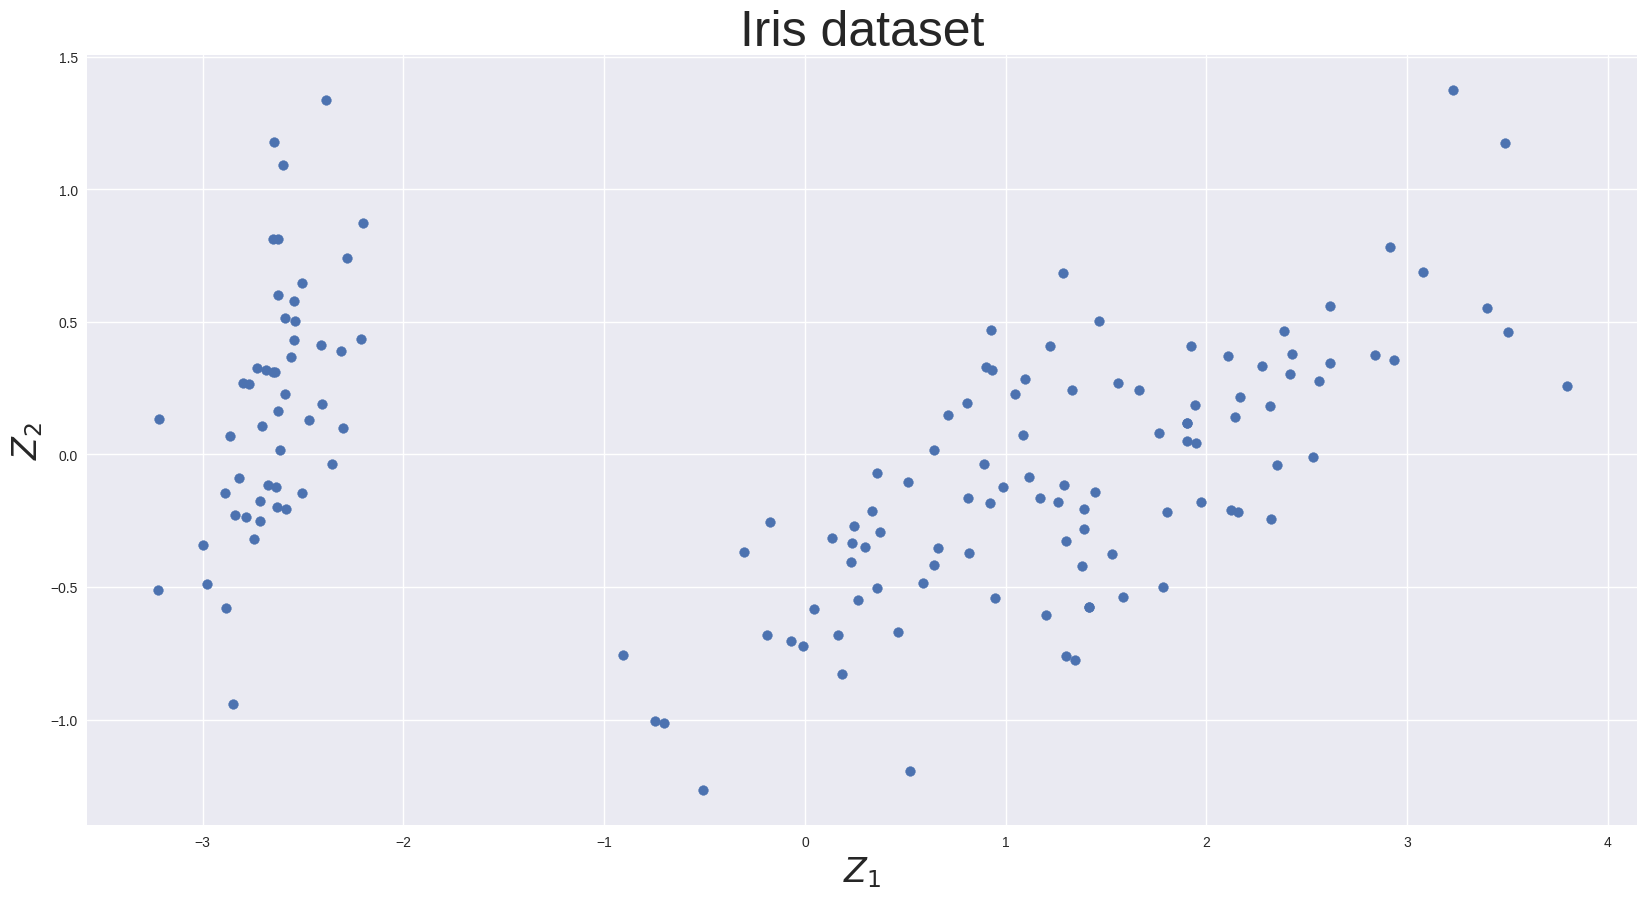

In [65]:
plot_unsup(data_iris, w=20, h=10, title="Iris dataset")

#### Initialization

- In this case, we know that $k=3$;
- We are going to pick **three points at random** to use as initial centroids

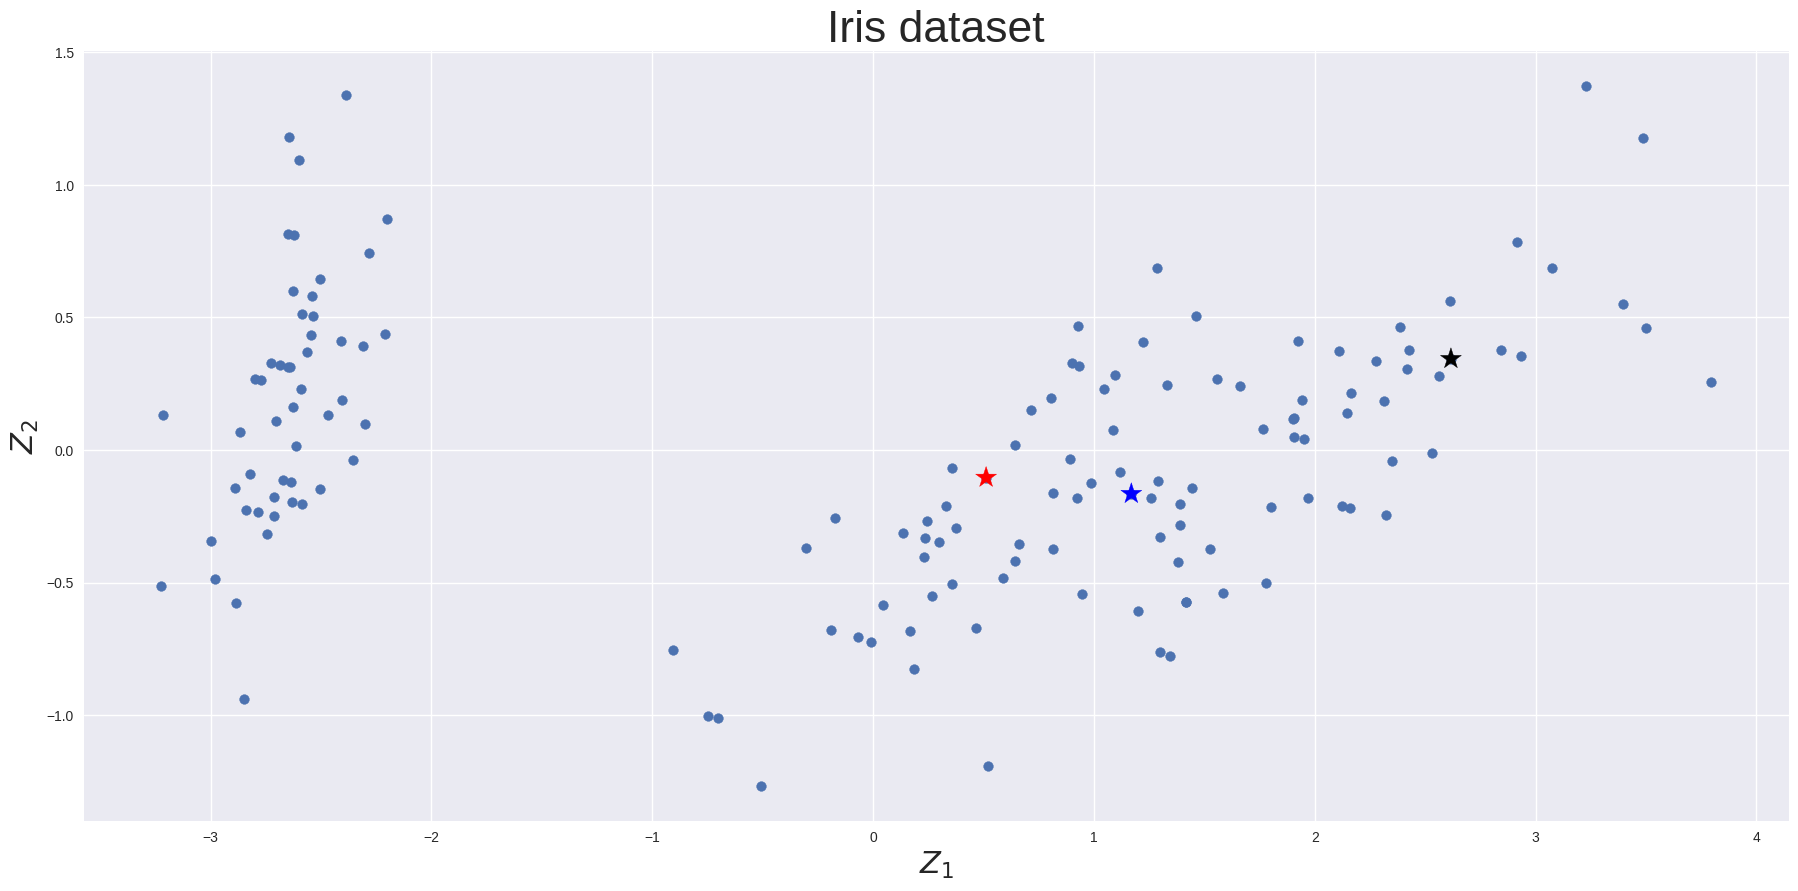

In [66]:
# RANDOM initialization
k = 3
centroids = np.random.choice(range(0, 150), size=k)
centroids = data_iris.iloc[centroids, 0:2]  # 3 random rows and 2 columns: Z1 and Z2
plot_intial_center(data_iris, centroids, w=22, h=10, title="Iris dataset")

- Next, for each point in the dataset, we calculate the distance to each one of the centroids;


- Let's do it for one point as example:

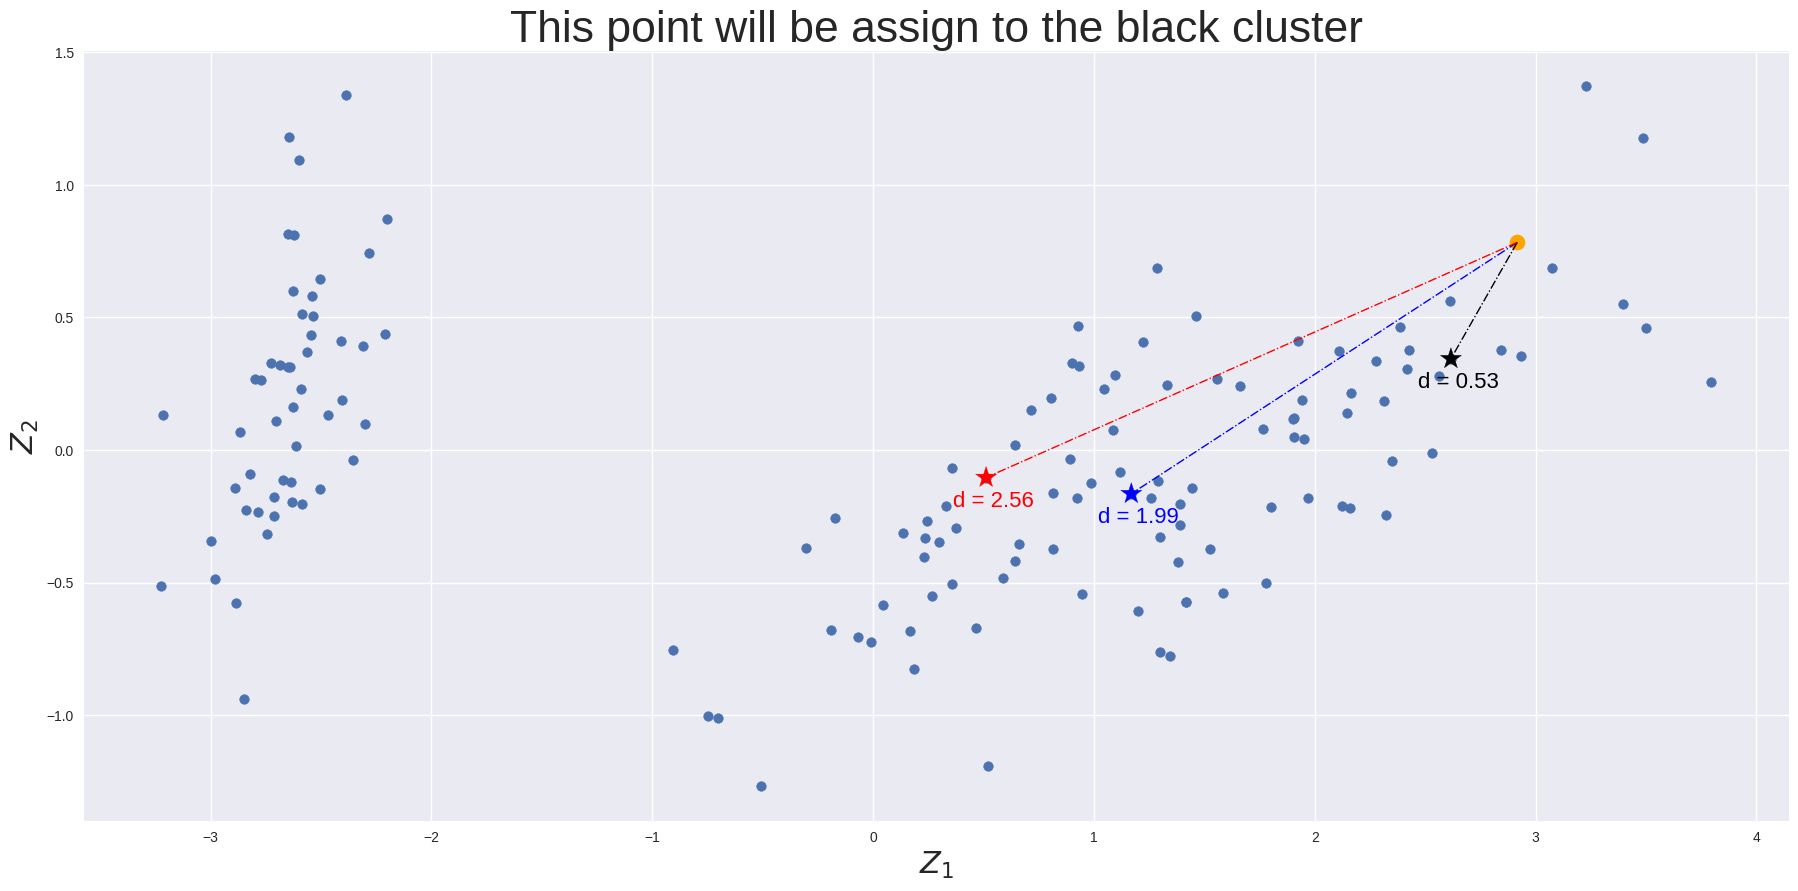

In [67]:
plot_example_dist(data_iris, centroids, w=22, h=10)

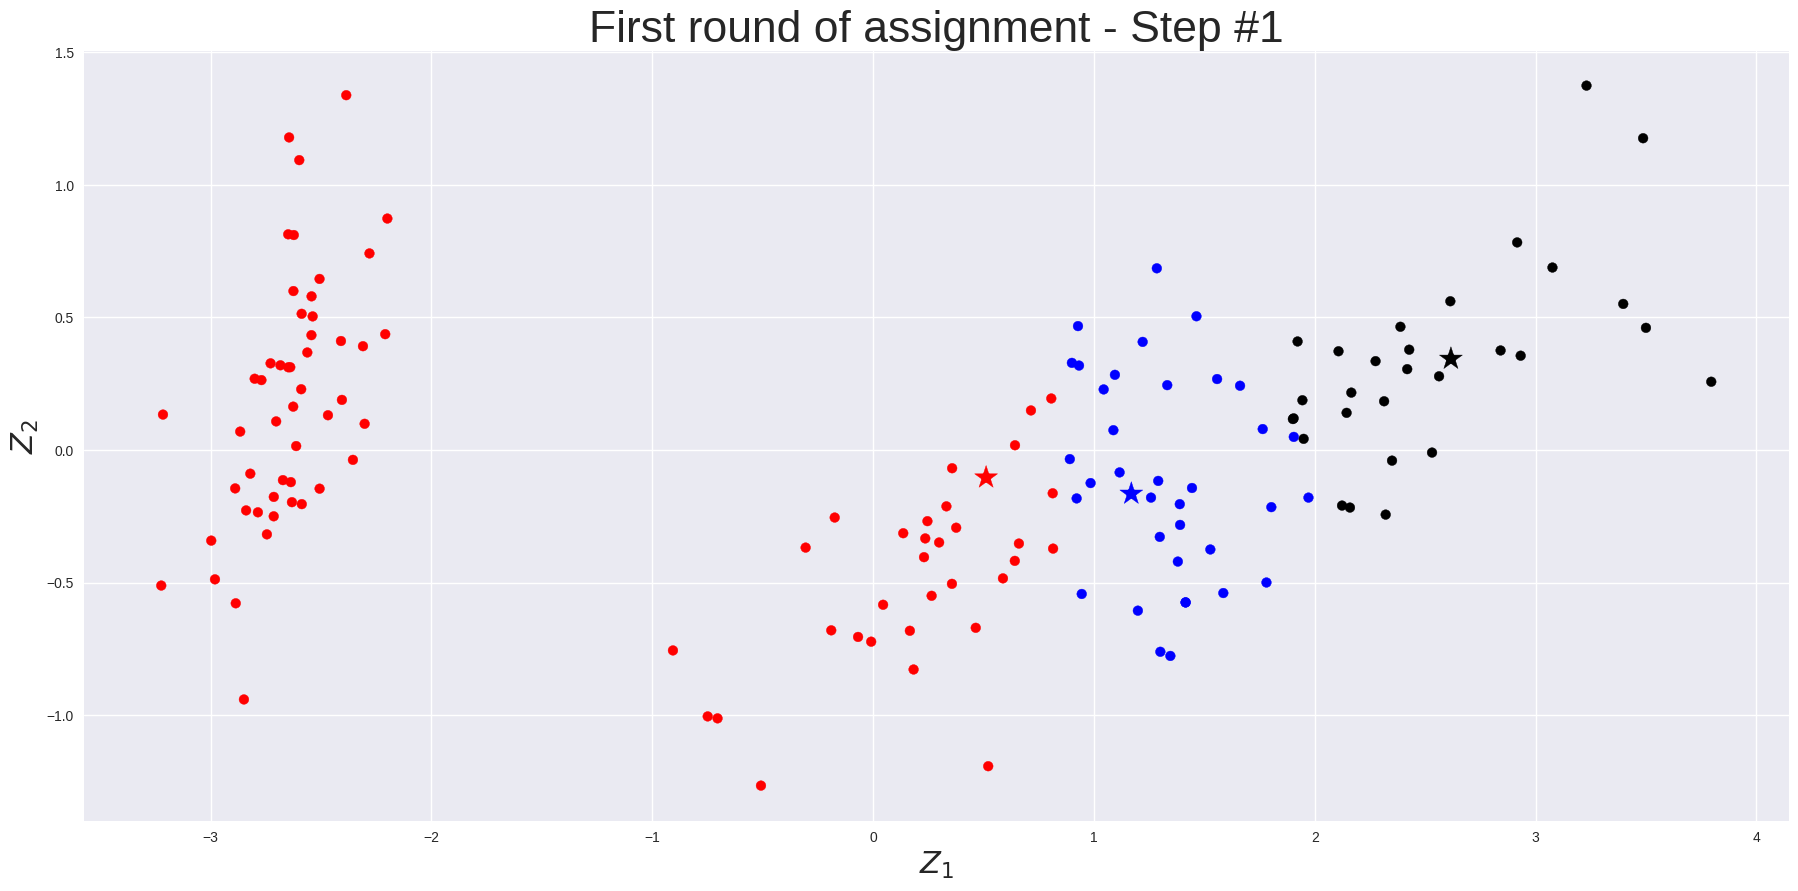

In [68]:
dist = distance.cdist(data_iris.iloc[:, 0:2], centroids.iloc[:, 0:2])
plot_first_assignment(data_iris, centroids, dist, w=22, h=10)

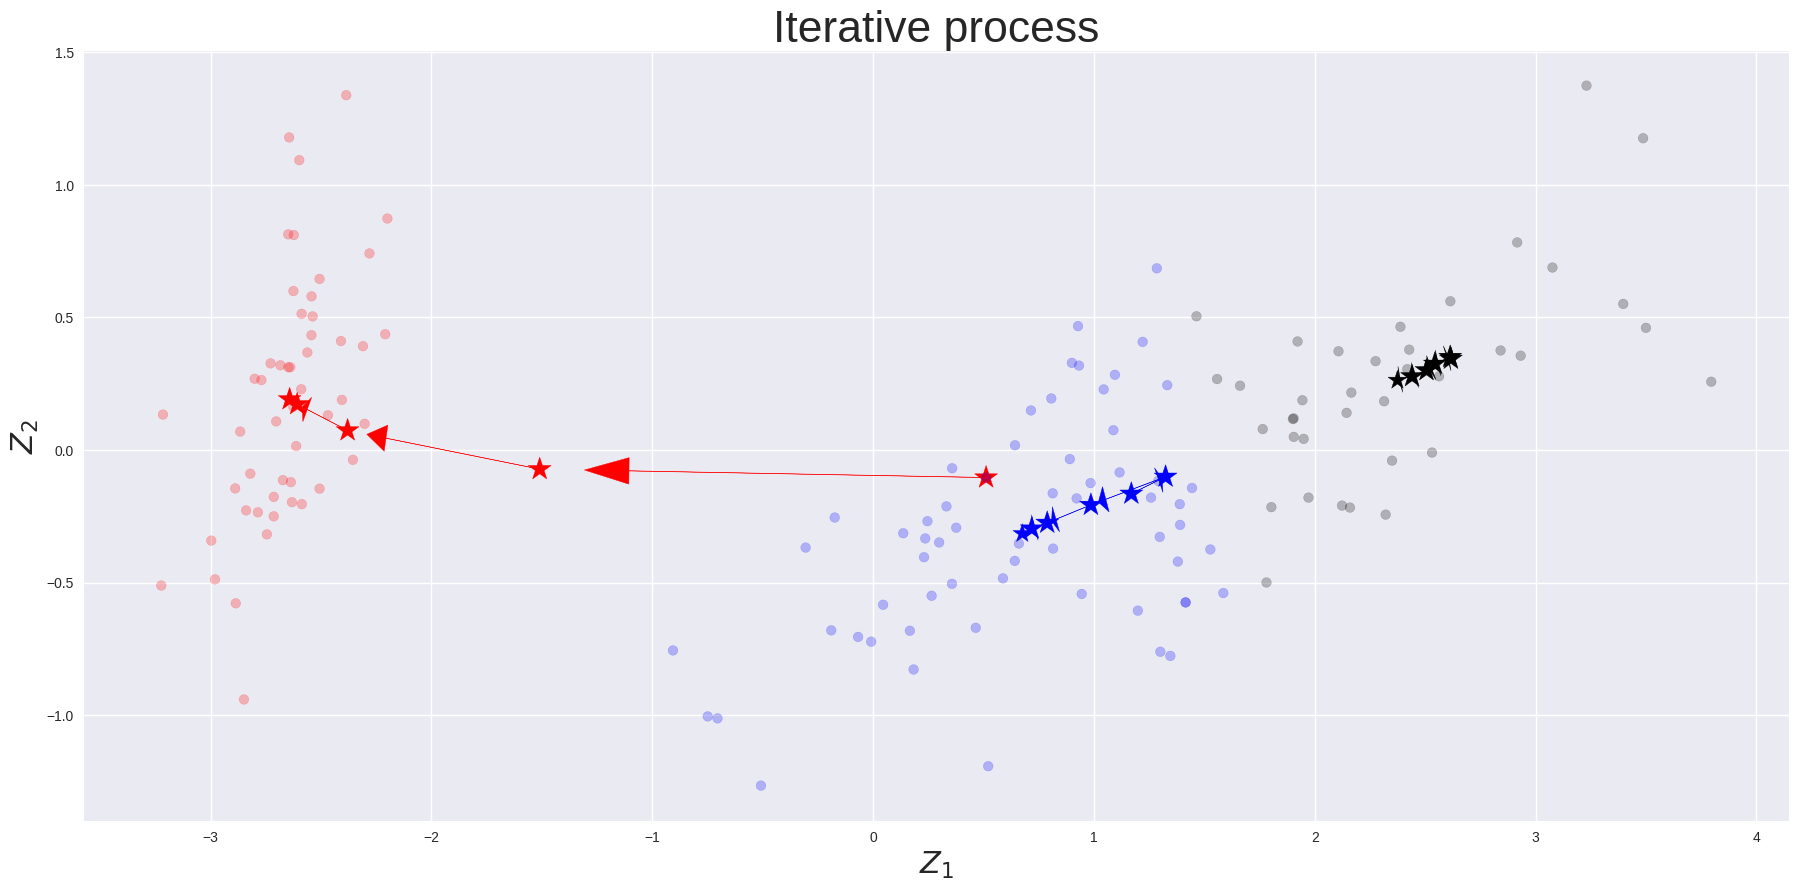

In [69]:
plot_iterative(data_iris, centroids.to_numpy(), w=22, h=10)

### (Optional) Feature engineering using K-Means

- K-Means could be used for feature engineering in supervised learning.
- Examples:
    - You could add a **categorical** feature: **cluster membership**
    - You could add a **continuous** features: **distance from each cluster center**
- See [this paper](http://ai.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf).

<br><br><br><br>

## Choosing K [[video](https://youtu.be/M5ilrhcL0oY)]

### Hyperparameter tuning for K

- K-Means takes K (`n_clusters` in `sklearn`) as a hyperparameter. How do we pick K?

- In supervised setting we carried out hyperparameter optimization based on cross-validation scores.

- Since in unsupervised learning we do not have the target values, it becomes difficult to objectively measure the effectiveness of the algorithms.

- There is no definitive approach.

- However, some strategies might be useful to help you determine K.

### The Elbow method

- This method looks at the sum of **intra-cluster distances**, which is also referred to as **inertia**.
- The intra-cluster distance in our toy example above is given as   

$$\sum_{P_i \in C_1}  distance(P_i, C_1)^2 + \sum_{P_i \in C_2}  distance(P_i, C_2)^2 + \sum_{P_i \in C_3} distance(P_i, C_3)^2$$

Where
- $C_1, C_2, C_3$ are centroids
- $P_i$s are points within that cluster
- $distance$ is the usual Euclidean distance.

### Inertia

You can access this intra-cluster distance or inertia as follows.

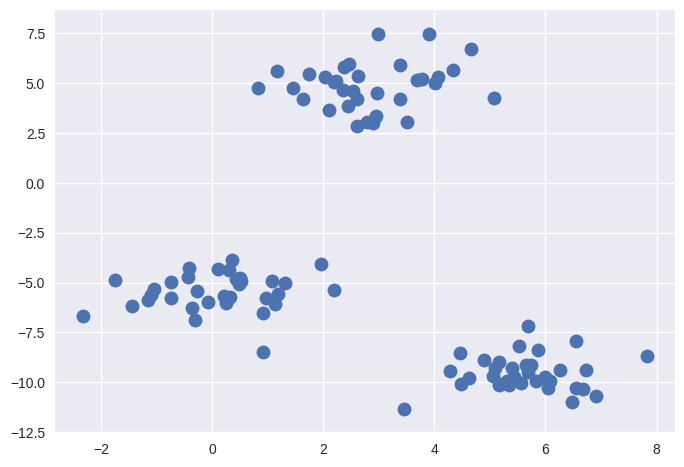

In [70]:
X, y = make_blobs(centers=3, n_features=2, random_state=10)
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o");

In [71]:
d = {"K": [], "inertia": []}
for k in range(1, 100, 10):
    model = KMeans(n_clusters=k).fit(X)
    d["K"].append(k)
    d["inertia"].append(model.inertia_)

In [72]:
pd.DataFrame(d)

K      inertia
0   1  4372.460950
1  11    61.786993
2  21    28.895525
3  31    12.965523
4  41     7.366616
5  51     4.503509
6  61     2.318956
7  71     1.031987
8  81     0.323788
9  91     0.053156

- The inertia **decreases** as K **increases**.
- Question: Do we **want** inertia to be **small** or **large**?
- The problem is that we can't just look for a $k$ that minimizes inertia because it decreases as $k$ increases.
    - If I have `number of clusters` = `number of examples`, each example will have its own cluster and the **intra-cluster distance will be 0**.
- Instead we evaluate the **trade-off**: "small k" vs "small intra-cluster distances".

In [73]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.axvline(x=3, linestyle="-.", c="black")
    plt.plot(range(1, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h) / 2)
    ax.set_xlabel("K", fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

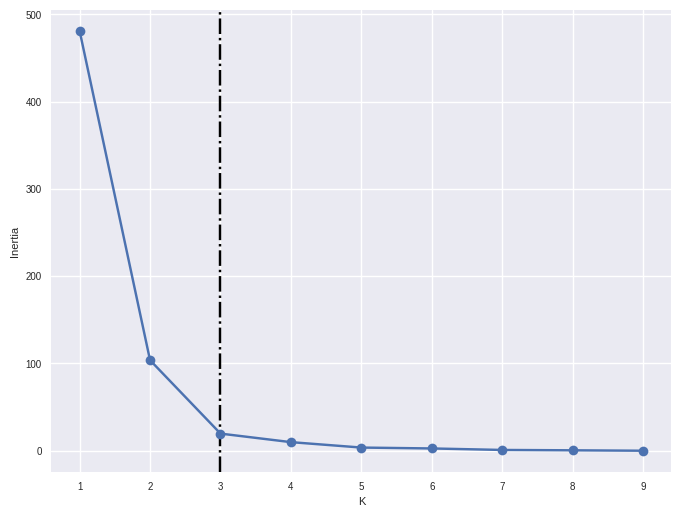

In [74]:
inertia_values = list()
for k in range(1, 10):
    inertia_values.append(KMeans(n_clusters=k).fit(toy_df).inertia_)
plot_elbow(8, 6, inertia_values)

- From the above plot, we could argue that three clusters (the point of inflection on the curve) are enough.
- The inertia decreases when clusters are greater than 3. However it's not a big improvement and so we prefer K=3.
- In this toy example, it's the plot is kind of clear and easy to interpret but it can be hard to interpret in real life examples.

There is a package called [`yellowbrick`](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) which can be used to create these plots conveniently.

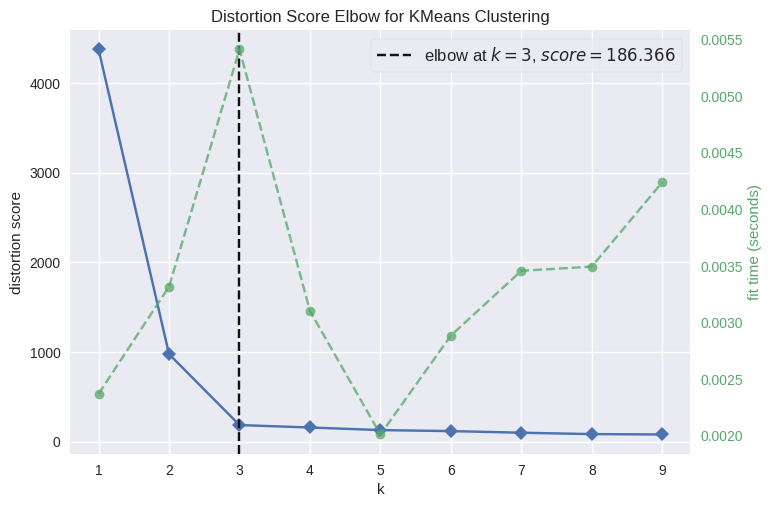

In [75]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show();

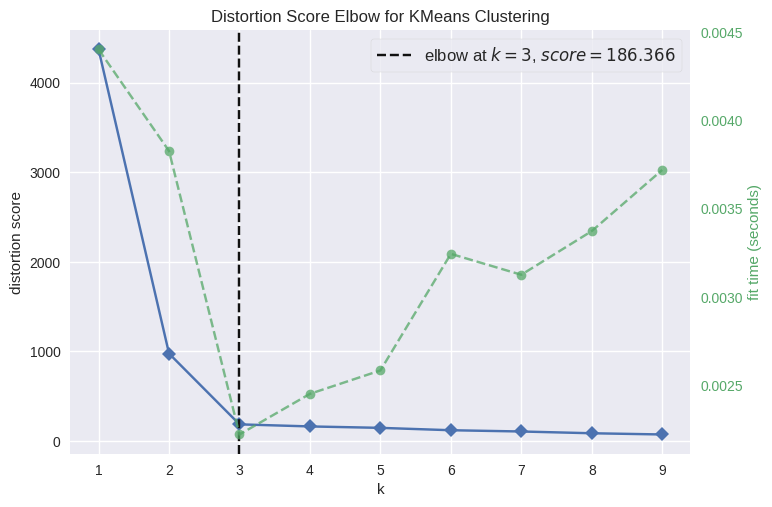

In [76]:
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.finalize();

<br><br>